# Notebook for dataset variable plotting

## Base imports

In [1]:
import os
from typing import Tuple, Dict
from collections import defaultdict
from copy import deepcopy
from itertools import product
import numpy as np
from scipy.stats import wasserstein_distance
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import mplhep as hep
import seaborn as sns
from ringer.constants import HOME_PATH, STEP_PREFIX
from ringer.utils import get_logger
from ringer.data import get_electron_label, get_jet_label, load_var_infos, NamedDatasetLoader
from ringer.regions import get_et_eta_regions
from ringer.constants import VAR_INFOS_DTYPES, DEFAULT_FIGSIZE, DEFAULT_DPI
from ringer.utils import medium_keys_mapping
from ringer.plotting import set_defaults
from ringer.crossval import ColumnKFold
from ringer.scalers import MinMaxScaler
plt.style.use(hep.style.ATLAS)
# plt.rc('legend',fontsize='large')
# plt.rc('axes',labelsize='x-large')
# plt.rc('text',usetex='false')
# plt.rc('xtick', labelsize='large')
# plt.rc('figure', figsize=DEFAULT_FIGSIZE)
# plt.rc('figure', dpi=DEFAULT_DPI)

ET_BINS = [15.0,20.0,30.0,40.0,50.0,100.0,np.inf]
ETA_BINS = [0,0.8,1.37,1.54,2.37,2.5]
set_defaults()
# ET_ETA_REGIONS = get_et_eta_regions(ET_BINS, ETA_BINS)
%matplotlib inline

### Functions

In [2]:
def histplot(data, x, xlabel:str=None, xrange=None, xbins=None, write_legend=True, xlim=None, ylim=None,
             title=None, orientation='vertical', ax=None, write_labels=True, density:bool=True,
             plot_scale='log', despine=True, write_samples=True, xlabel_loc='right'):
    
    if write_labels:
        xlabel = x if xlabel is None else xlabel
        ylabel = 'Density' if density else 'Counts'
    else:
        xlabel = None
        ylabel = None
    
    ax = plt.gca() if ax is None else ax
    hists = dict()
    patches = dict()
    if type(xbins) is not dict:
        xbins = dict.fromkeys(data.keys(), xbins)
    if type(xrange) is not dict:
        xrange = dict.fromkeys(data.keys(), xrange)
    
    for data_name, data_df in data.items():
        n_samples = '{:.3e}'.format(len(data_df))
        if write_labels:
            label = f'{data_name} {n_samples} samples'
        else:
            label = f'{data_name}'
        hist, bins, patch = ax.hist(data_df[x], bins=xbins[data_name], label=label,
                                     density=density, range=xrange[data_name], histtype='step', orientation=orientation)
        hists[data_name] = (hist, bins)
        patches[data_name] = patch
    
    ax.set(xlim=xlim, ylabel=ylabel, yscale=plot_scale, ylim=ylim)
    ax.set_xlabel(xlabel, loc=xlabel_loc)
    if write_legend:
        ax.legend()
    if title is not None:
        ax.set_title(title, fontsize='xx-large')
    if despine:
        if type(despine) is bool:
            sns.despine(ax=ax)
        else:
            sns.despine(ax=ax, **despine)
    
    return ax, hists, patches

In [3]:
def get_plot_data(data, sort, cross_val, pipeline=None):
    has_pipeline = pipeline is not None
    plot_data = {}
    for sort_type in ["train", "test"]:
        is_train =sort_type == "train"
        plot_data[sort_type] = dict()
        for class_, class_df in data.items():
            if is_train:
                selection_idx = cross_val.get_train_idx(class_df, sort) 
            else:
                selection_idx = cross_val.get_test_idx(class_df, sort)
            plot_data[sort_type][class_] =class_df[selection_idx]
            
        if has_pipeline and is_train:
            plot_data[sort_type] = pipeline.fit_transform(plot_data[sort_type])
        elif has_pipeline and (not is_train):
            plot_data[sort_type] = pipeline.transform(plot_data[sort_type])
    return plot_data

### Args

In [4]:
test=True
vars2plot = ["trig_L2_cl_reta"]
total_folds = 10
sort = 3
plot_logger = get_logger('plot_log', file=False)
home_path = os.path.expanduser("~")
step = 'offline'

In [5]:
script_datetime = datetime.now()
script_time_str = script_datetime.strftime("%Y_%m_%d_%H_%M_%S")
output_dir = os.path.join(home_path, 'data', f'{script_time_str}_exploratory_analysis_per_fold')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Loading data

In [6]:
cross_val = ColumnKFold(n_folds=total_folds, sequential_col_name='region_id')
var_infos = load_var_infos()
var_infos

,name,label,type,formula,description
col,,,,,
trig_L2_cl_et,et,$E_T$,var,NaN,Transverse particle energy on the calorimeter ...
el_et,et,$E_T$,var,NaN,Transverse particle energy on the calorimeter ...
trig_L2_cl_eta,eta,$\eta$,var,NaN,Pseudorapidity (L2Calo stage)
el_eta,eta,$\eta$,var,NaN,Pseudorapidity (Offline stage)
trig_L2_cl_reta,reta,$R_{\eta}$,shower_shape,$R_{\eta} = \frac{E^{3x7}_{EM2}}{E^{7x7}_{EM2}}$,Ratio of the energy in 3x7 cells over the ener...
trig_L2_cl_eratio,eratio,$E_{ratio}$,shower_shape,$E_{ratio} = \frac{E^{max}_{EM1} - E^{2^{nd}ma...,Ratio of the energy difference between the max...
trig_L2_cl_f1,f1,$f_1$,shower_shape,$f_1 = \frac{E^{total}_{EM1}}{E^{total}_{EM}}$,Ratio of the energy in the first layer to the ...
trig_L2_cl_ehad1,ehad1,$E_{had1}$,unidentified,NaN,Unidentified (L2Calo Stage)
trig_L2_cl_f3,f3,$f_3$,shower_shape,$f_3 = \frac{E^{total}_{EM3}}{E^{total}_{EM}}$,Ratio of the energy in the third layer to the ...


In [7]:
boosted_data = NamedDatasetLoader('mc16_boosted', test) \
    .load_data_df(columns=vars2plot + ["id", "region_id"])
# boosted_data['source'] = 'MC16 Boosted el'
# boosted_data['source'] = boosted_data['source'].astype('category')
boosted_data.head()

,trig_L2_cl_reta,id,region_id
1452,0.972986,1452,38154
1453,0.973886,1453,14731
1454,0.965323,1454,4676
1455,0.970706,1455,24629
1456,0.970724,1456,10624


In [8]:
load_cols = vars2plot + ["id", "region_id", "target"]
medium_col_mapping = medium_keys_mapping(load_cols)
collision_data = NamedDatasetLoader('2017_medium', test) \
    .load_data_df(columns=list(medium_col_mapping.keys())) \
    .rename(medium_col_mapping, axis=1)
el_data = collision_data[collision_data["target"] == 1]
jet_data = collision_data[collision_data["target"] == 0]
del collision_data
# el_data['source'] = 'Data17 Zee el'
# el_data['source'] = el_data['source'].astype('category')
# jet_data['source'] = 'Data17 Zee jet'
# jet_data['source'] = jet_data['source'].astype('category')
el_data.head()

,trig_L2_cl_reta,id,region_id,target
0,0.954512,27639419,7,1
1,0.963367,27639420,5,1
2,0.963778,27639421,8,1
3,0.966769,27639422,18,1
4,0.967970,27639423,17,1


In [9]:
data = {
    'MC16 Boosted el': boosted_data,
    'Data17 Zee el': el_data,
    'Data17 Zee jet': jet_data
}

## 1D Hist plots

In [10]:
plot_kwargs = {
    "trig_L2_cl_reta": {
        "plot_normalized": True
    }
}


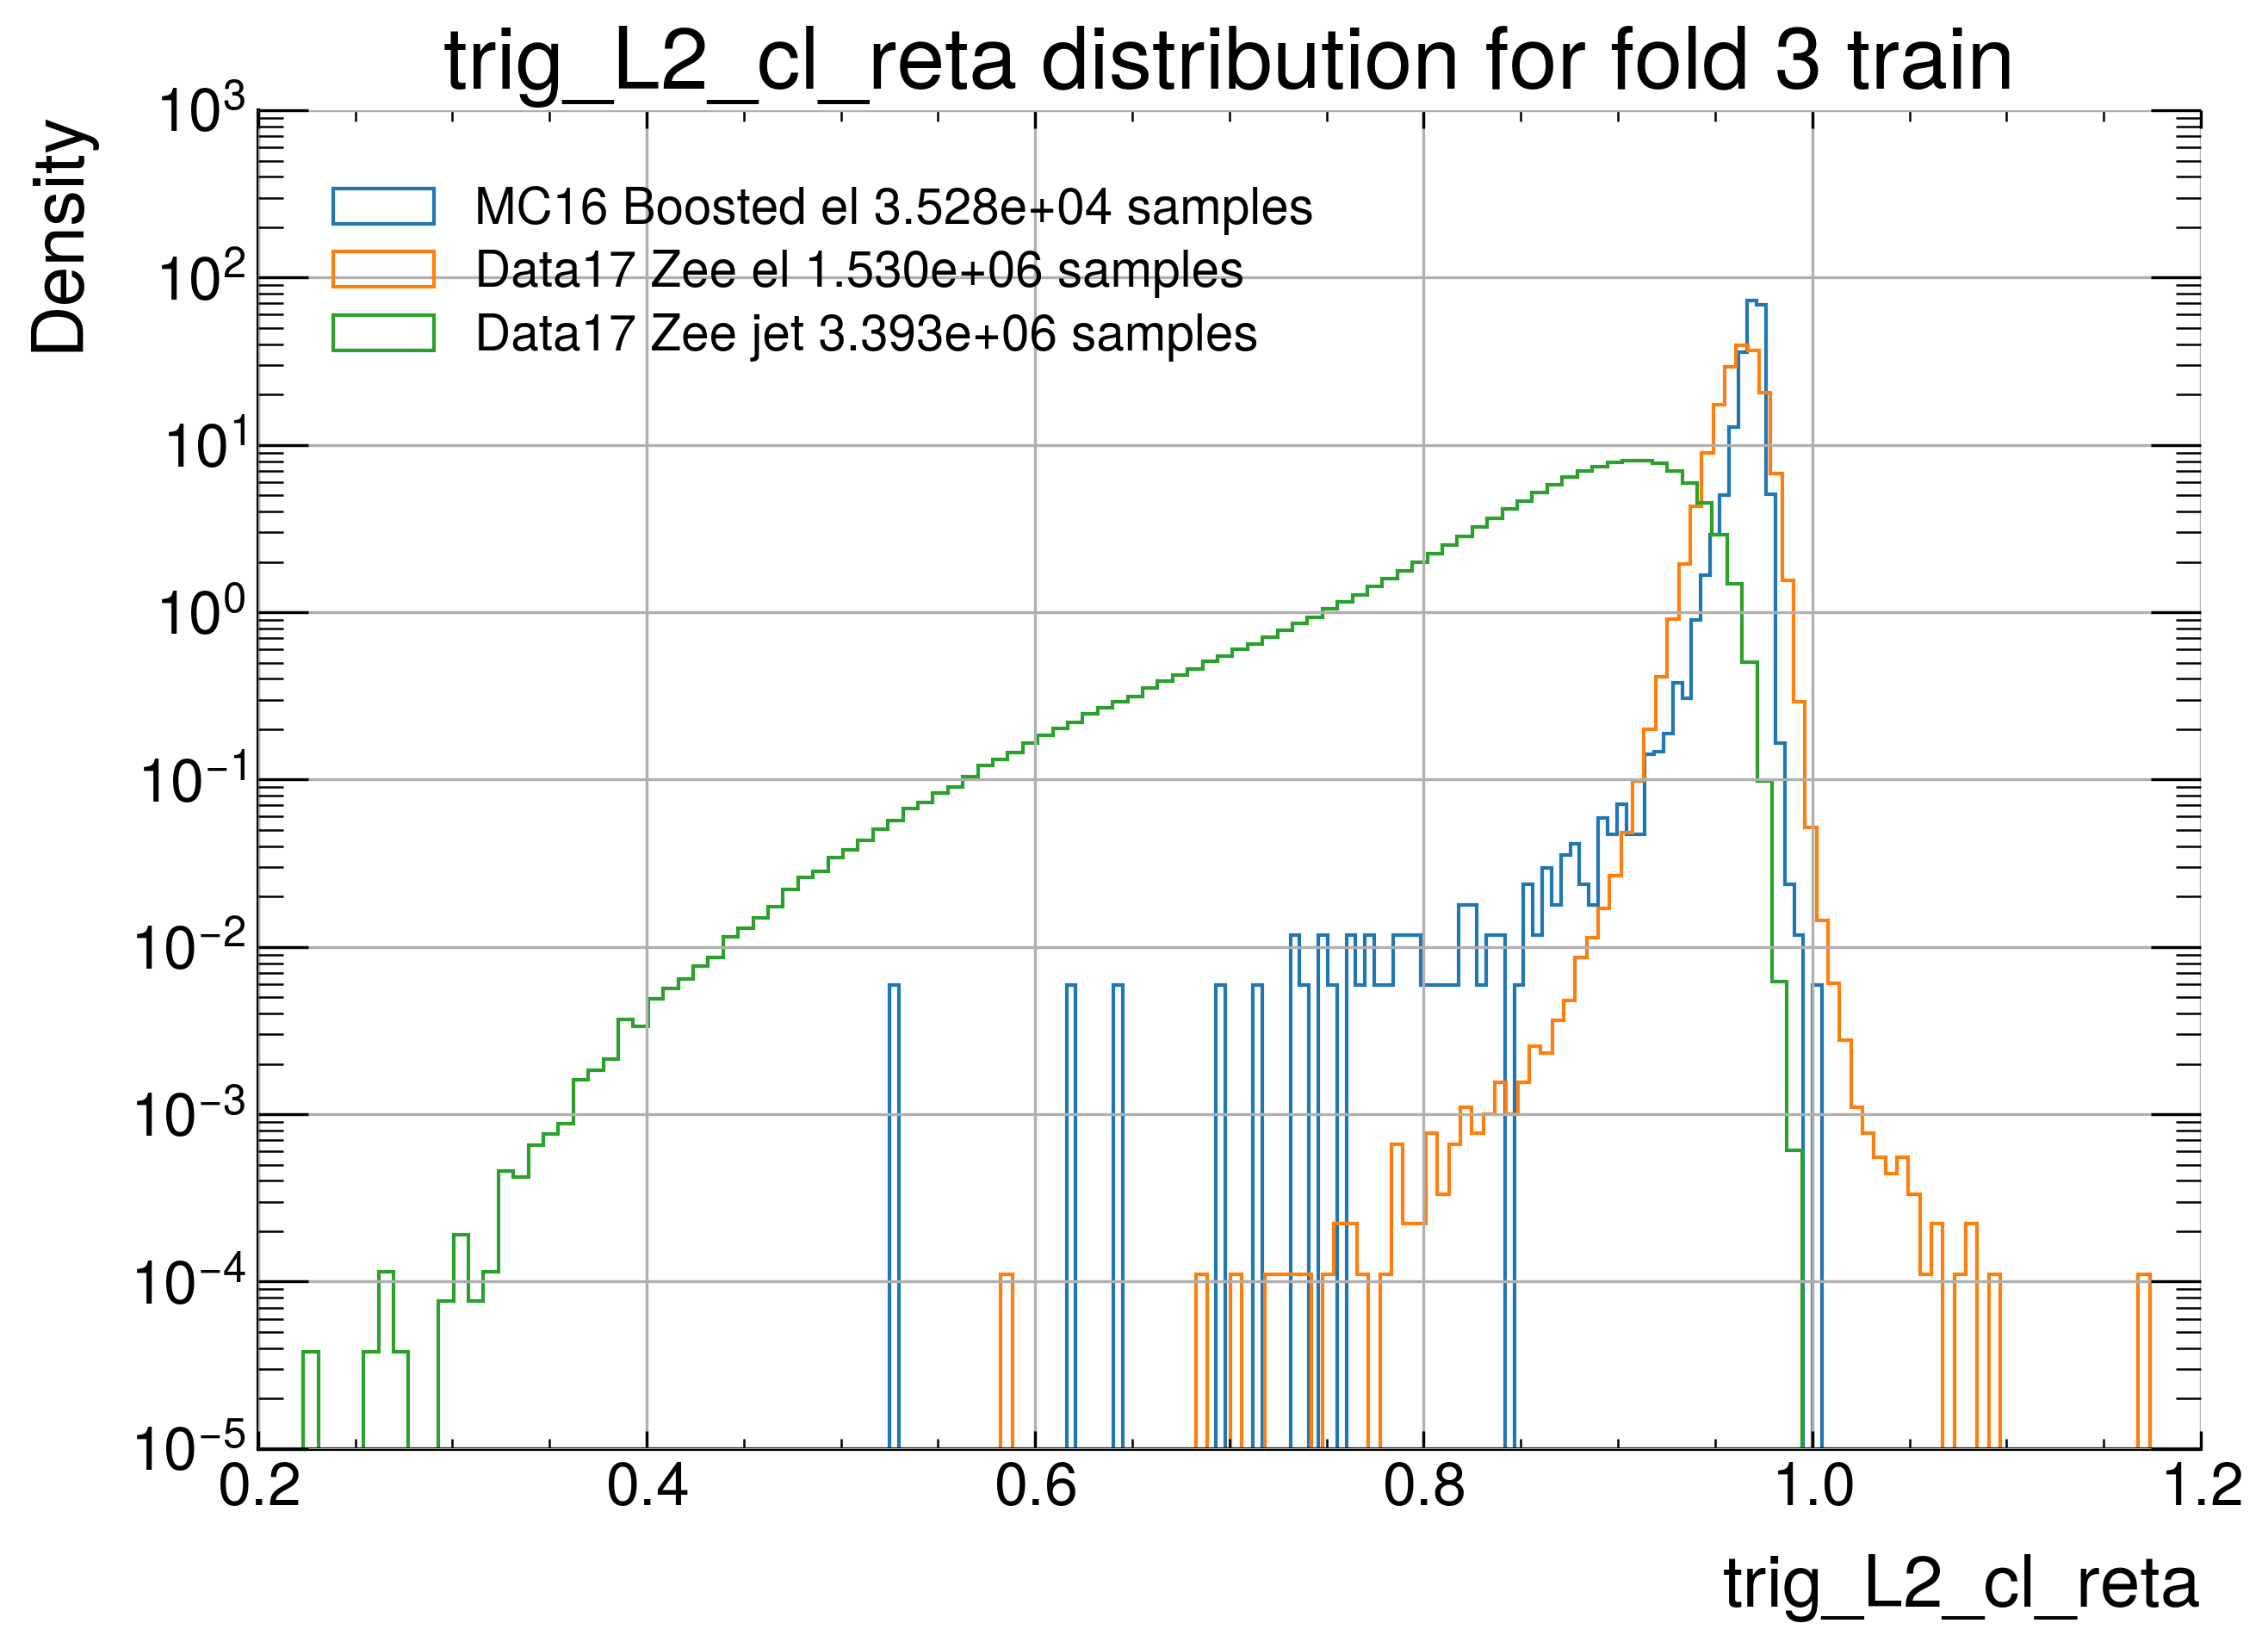

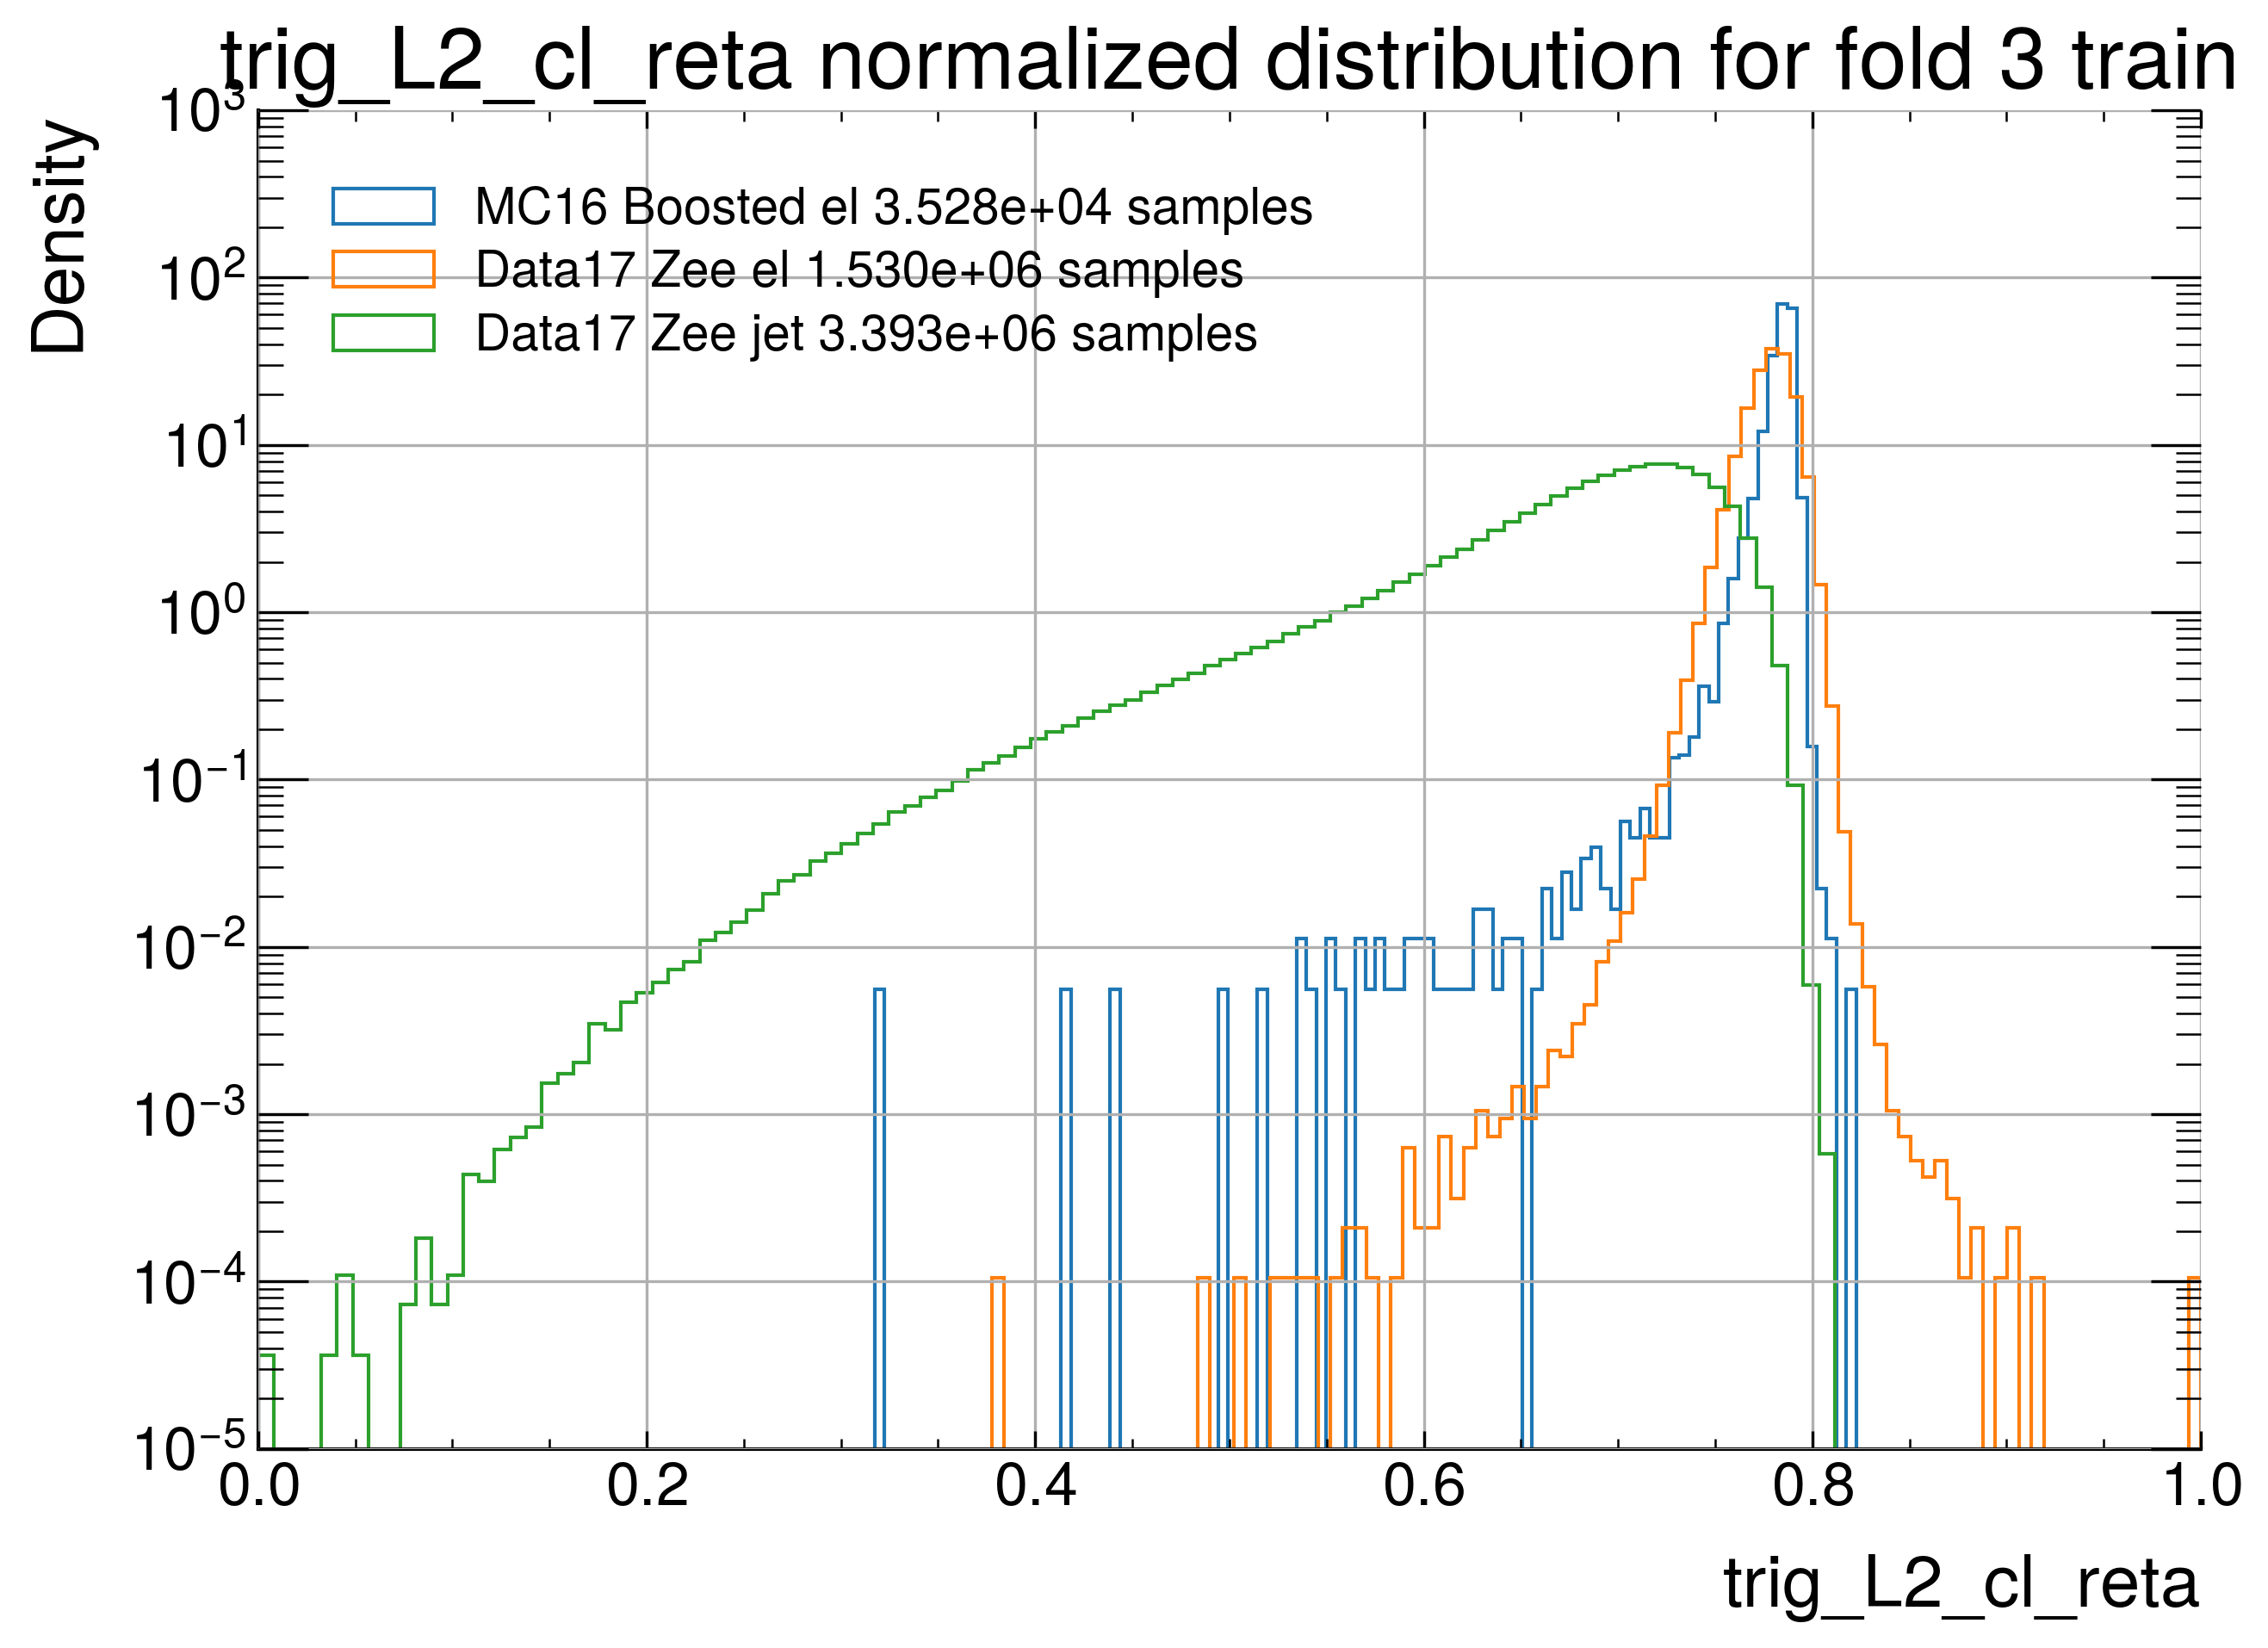

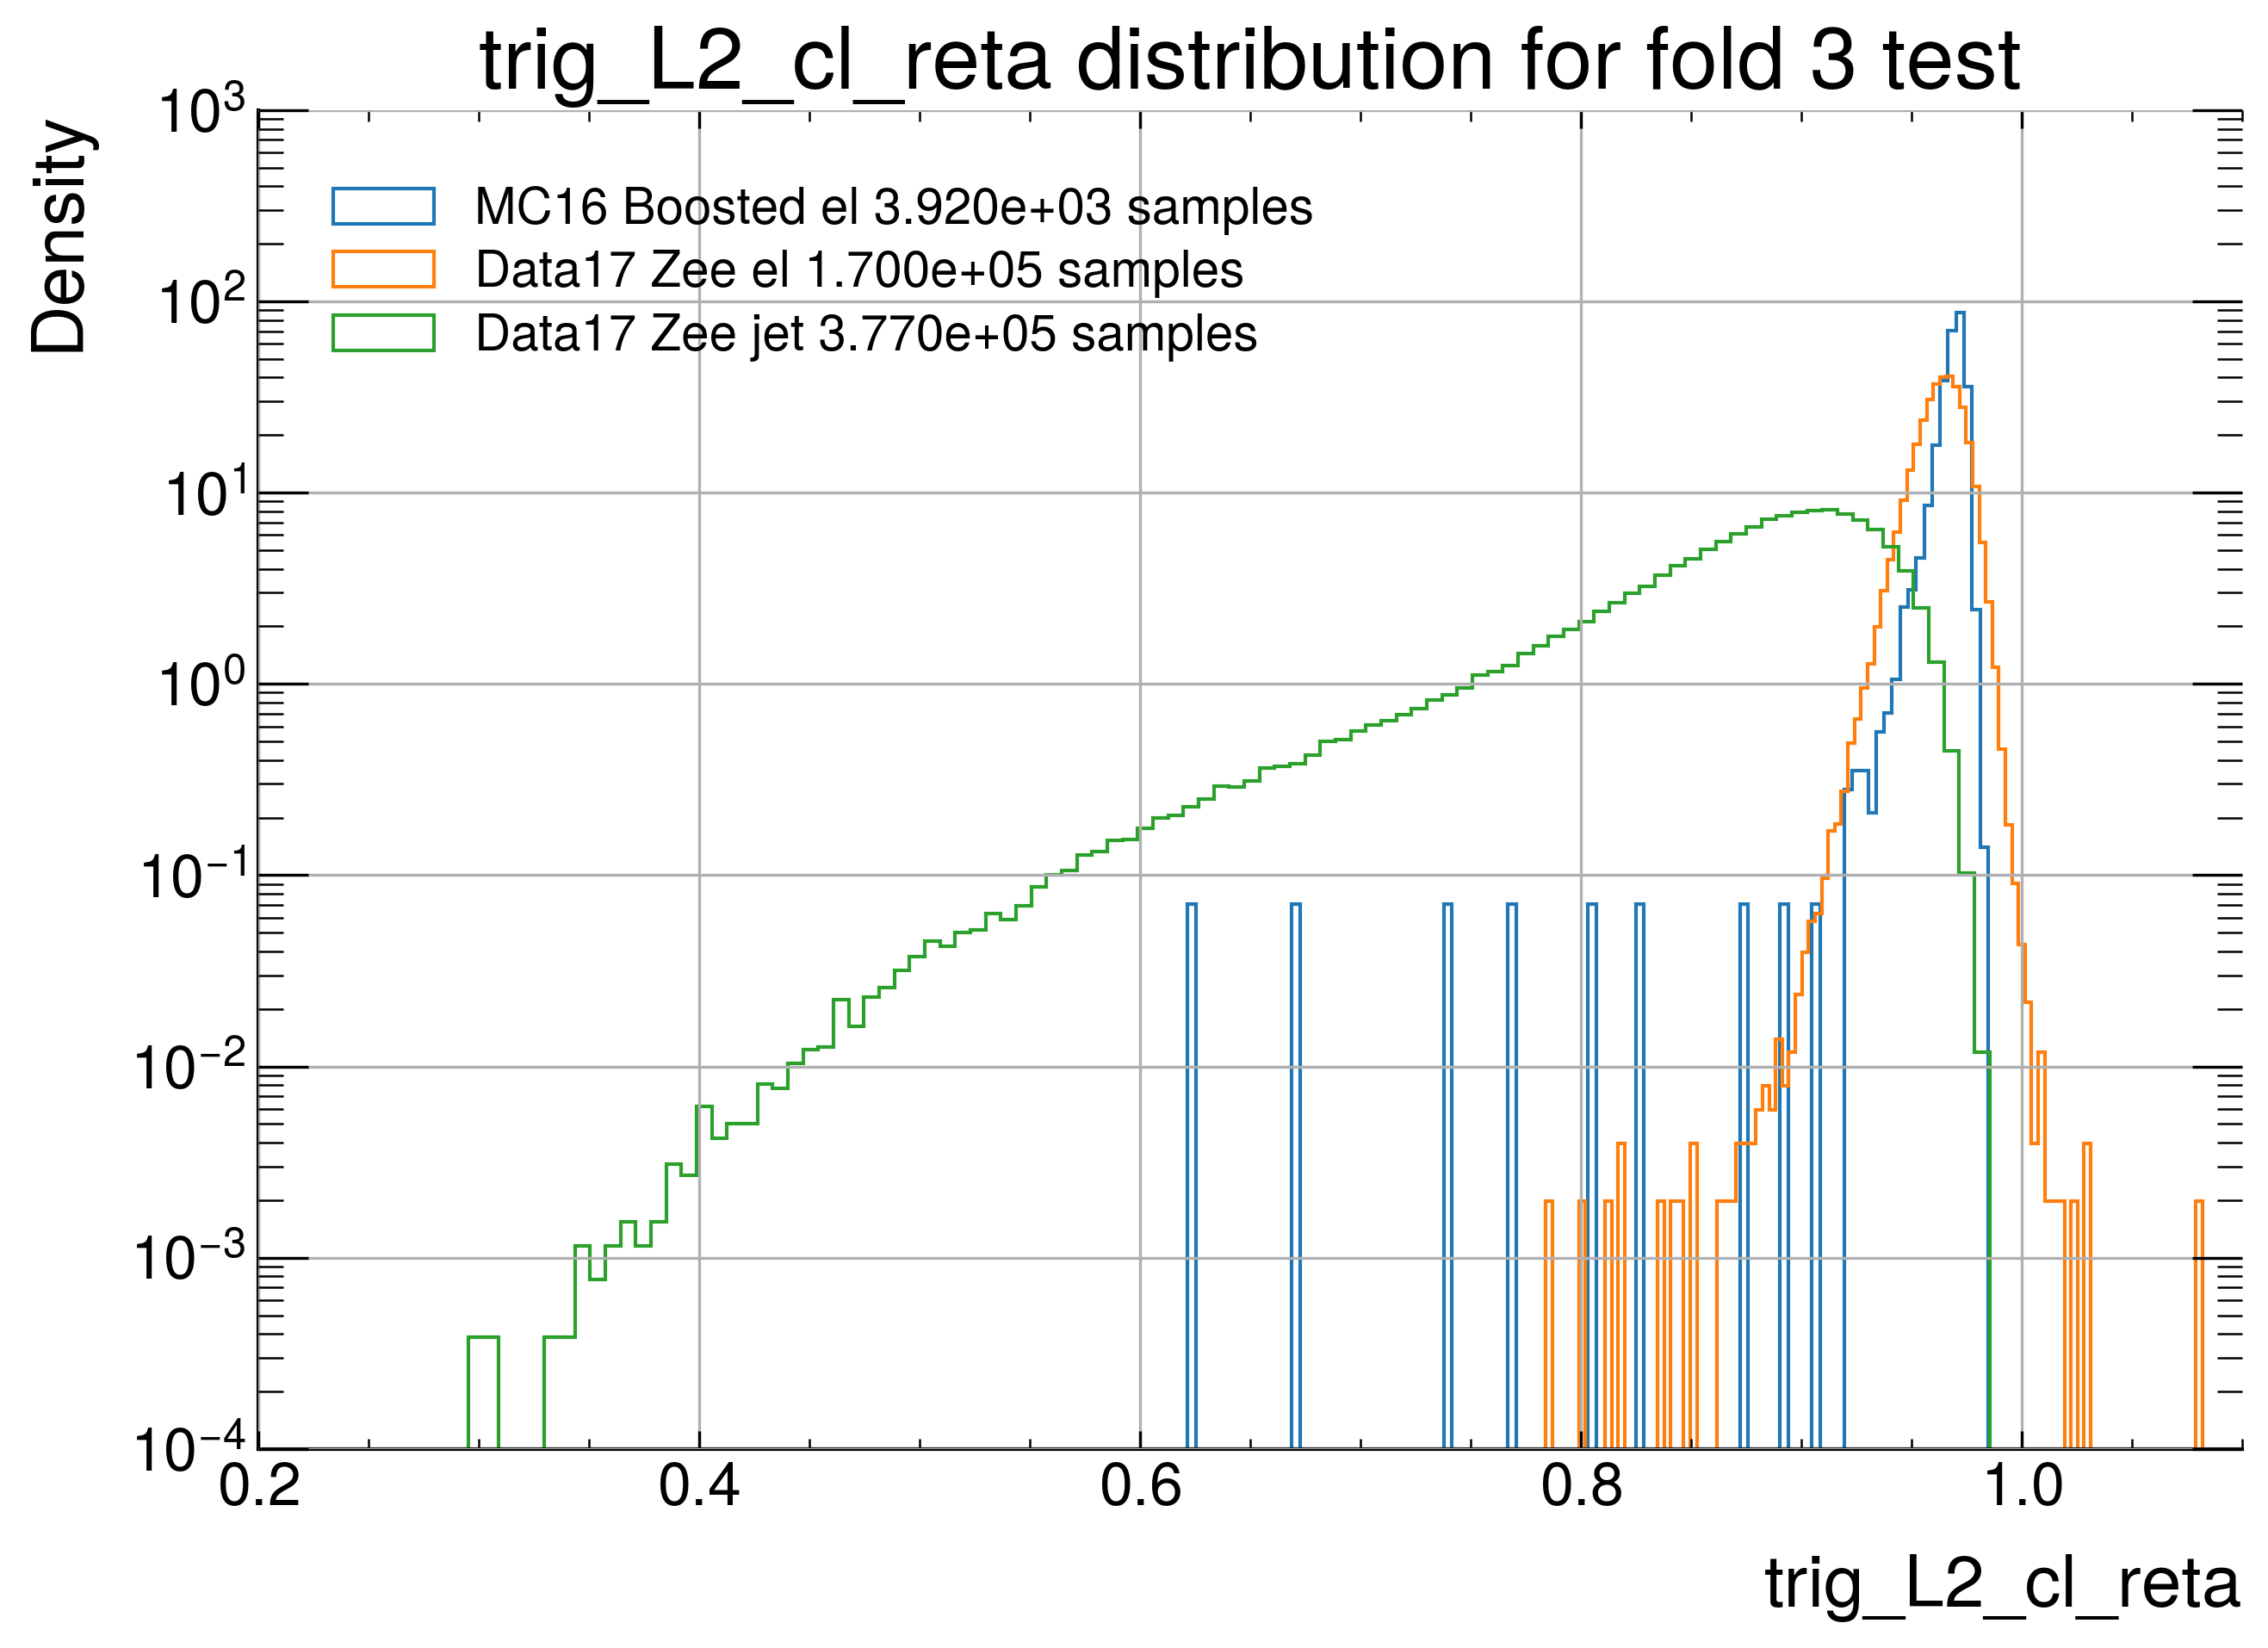

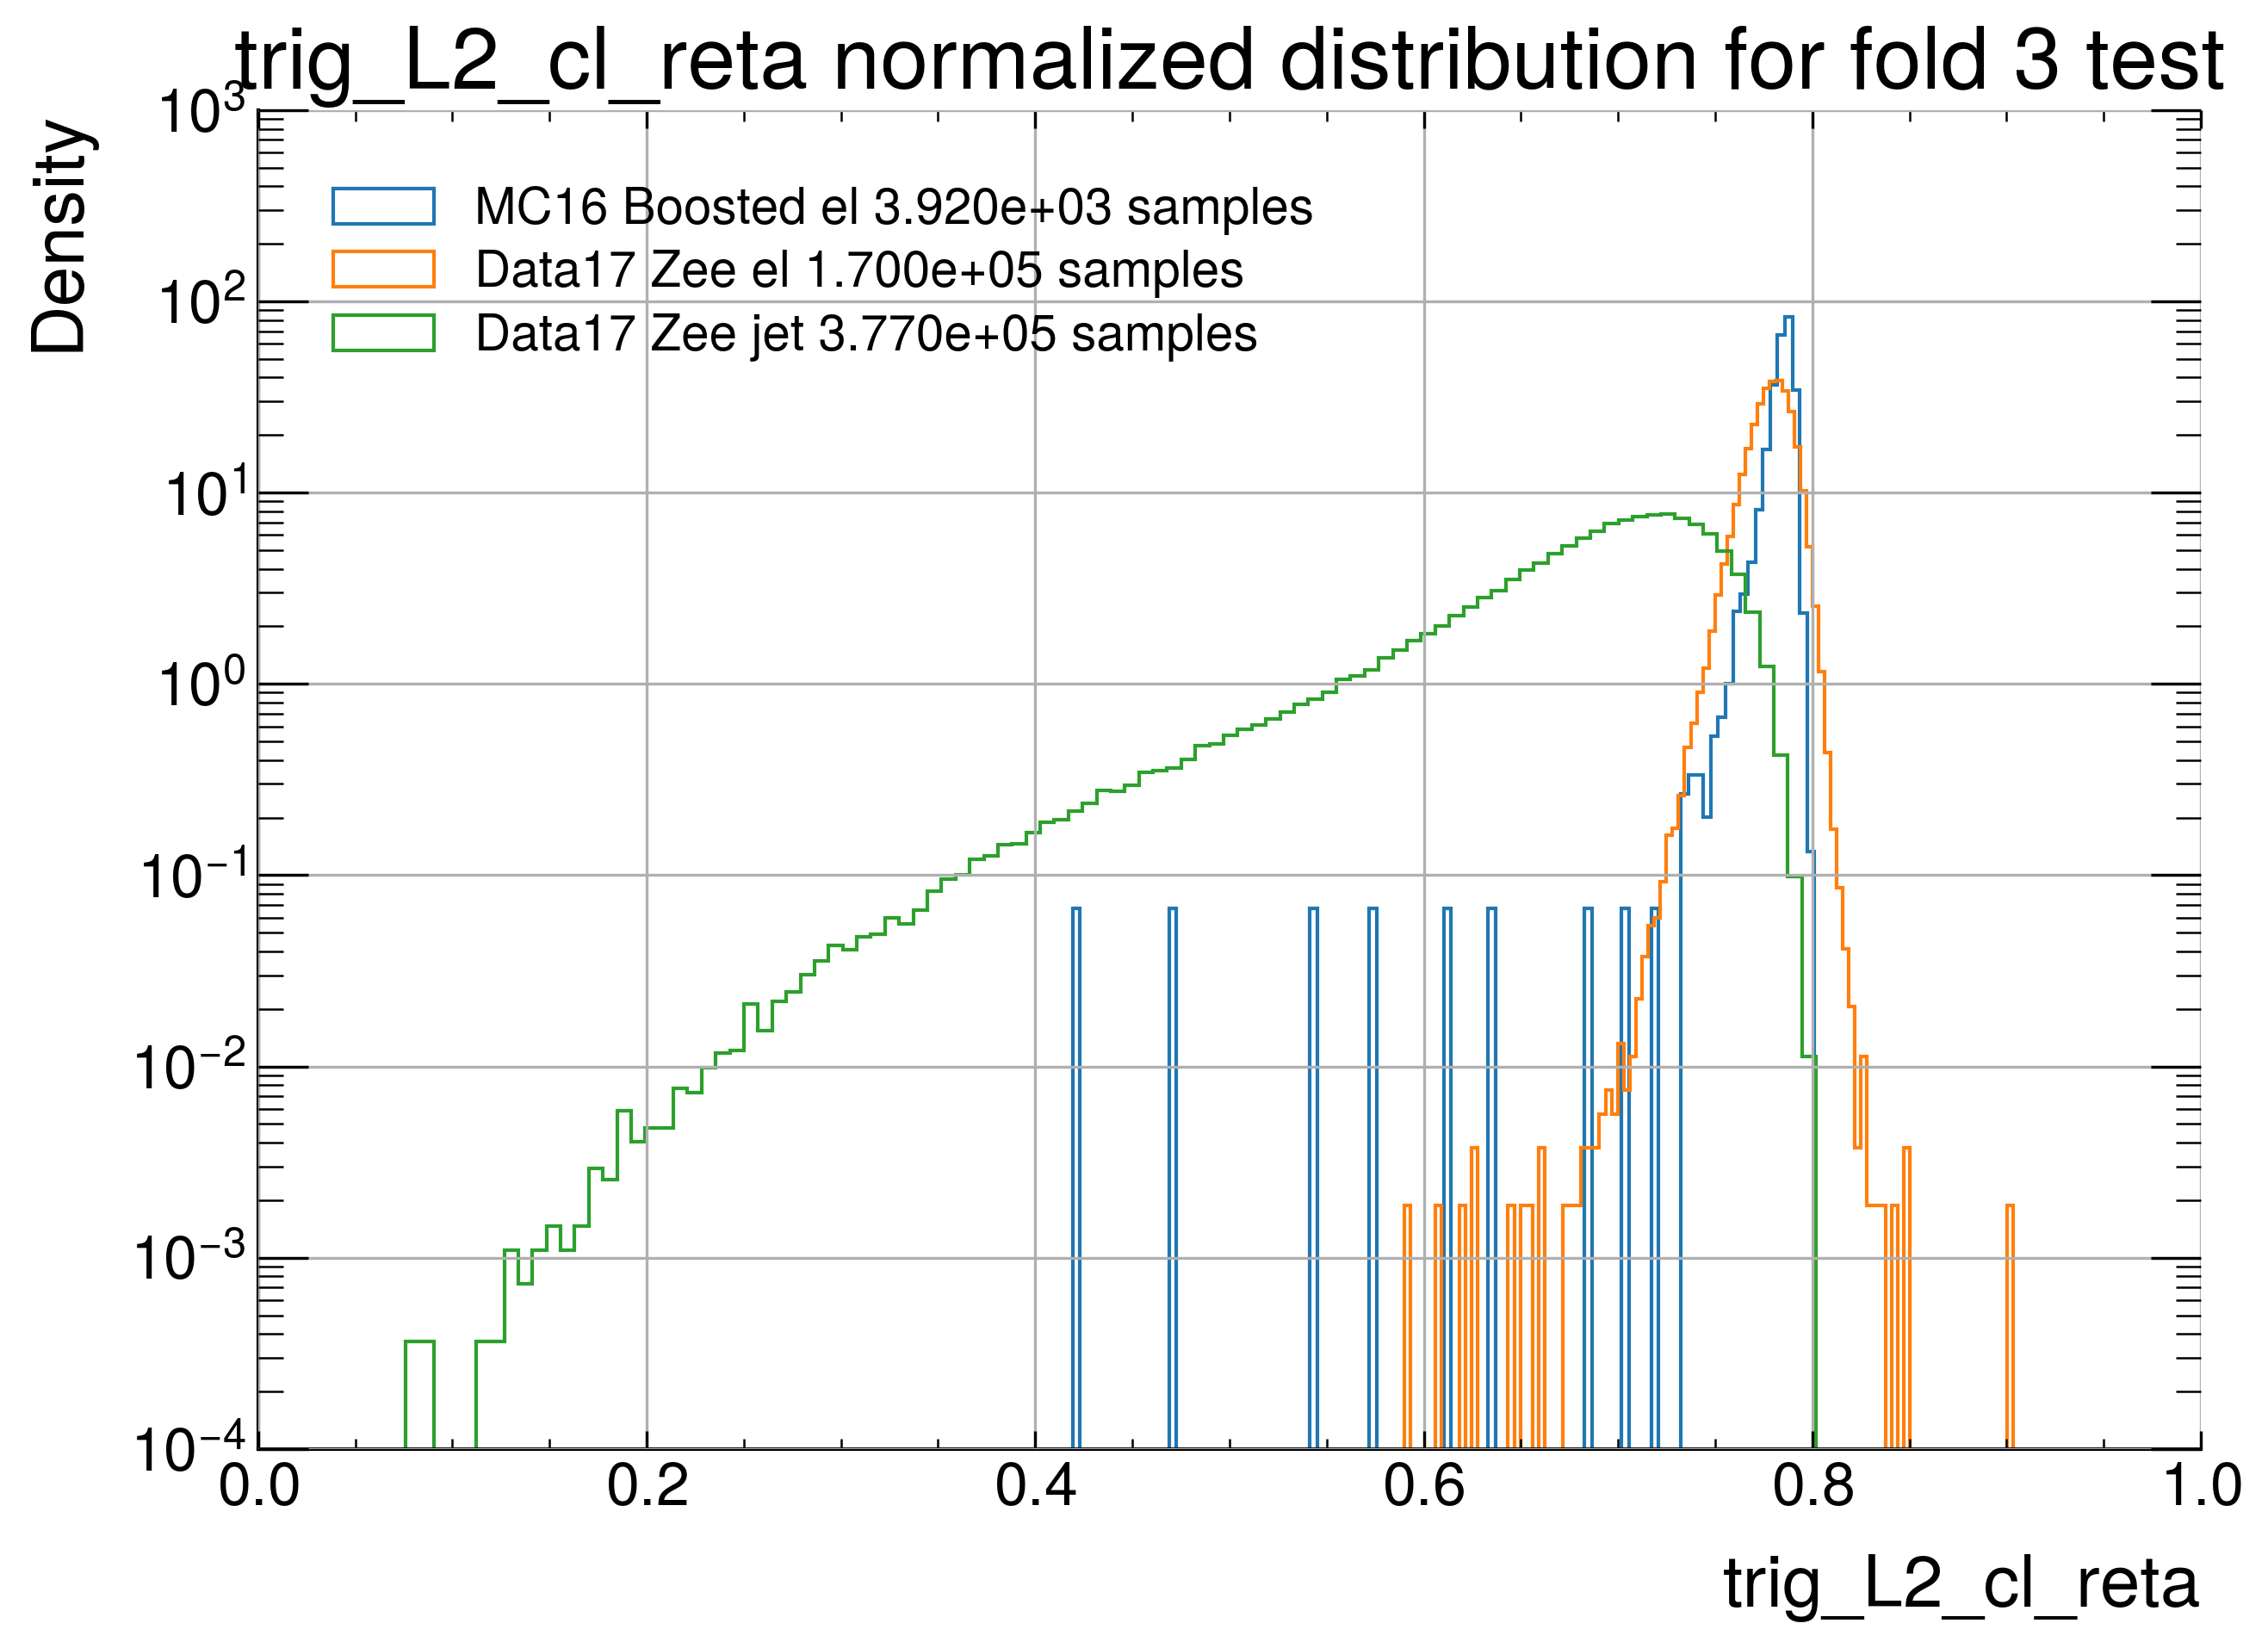

In [11]:
plots = dict()
plot_data = get_plot_data(data, sort, cross_val)
normalized_plot_data = get_plot_data(data, sort, cross_val, MinMaxScaler())
plot_dir = os.path.join(output_dir, "histplots")
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
for plot_var in vars2plot:
    plots[plot_var] = dict()
    for sort_type, sort_plot_data in plot_data.items():
        fig, ax = plt.subplots()
        plots[plot_var][sort_type] = (fig, ax)
        histplot(plot_data[sort_type], plot_var, ax=ax, write_labels=True, density=True,
                 plot_scale='log', despine=True, xlabel_loc='right', xbins=100,
                 title=f"{plot_var} distribution for fold {sort} {sort_type}",
                 write_legend=False)
        ax.legend(loc=2)
        ax.grid()
        fig.tight_layout()
        filename = f"{plot_var}_fold_{sort}_{sort_type}_histplot.png"
        fig.savefig(os.path.join(plot_dir, filename))
        if plot_kwargs[plot_var]["plot_normalized"]:
            fig, ax = plt.subplots()
            plots[plot_var][sort_type] = (fig, ax)
            histplot(normalized_plot_data[sort_type], plot_var, ax=ax, write_labels=True, density=True,
                     plot_scale='log', despine=True, xlabel_loc='right', xbins=100,
                     title=f"{plot_var} normalized distribution for fold {sort} {sort_type}",
                     write_legend=False)
            ax.legend(loc=2)
            ax.grid()
            fig.tight_layout()
            filename = f"{plot_var}_fold_{sort}_{sort_type}_minmax_normalized_histplot.png"
            fig.savefig(os.path.join(plot_dir, filename))

## End

In [12]:
plt.close('all')